In [390]:
# Use this cell to regroup all your imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import set_config; set_config(display='diagram')

In [422]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.linear_model import Ridge
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OrdinalEncoder

# 🏆 Le Wagon Kaggle Batch Challenge

<img src='https://github.com/lewagon/data-images/blob/master/ML/kaggle-batch-challenge.png?raw=true' width=600>

🏆 Welcome to your first Kaggle competition!

Your objective is to **submit online an answer** to the open competition [House Prices - Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

- Fortunately, you have already come across the house dataset in the bootcamp!
- You will be semi-guided up to a **baseline model**
- Only after will you be free to improve & refine your models
- We will approach the problem through **pipelines** (the best practice to take!)

A word on Kaggle:
- Kaggle will rank your submission amongst all participants!
- But don't worry, everyone is publicly removed from the leaderboard after 2 months
- You can make to 10 submissions per day

🧹 Today is the perfect day to practice keeping your long notebook **tidy** 🧹
- "Collapse all headings" from the "command palette" (Cmd + Shift + P)
- Stay idempotent (restart & run all should never crash)
- Name and delete variables carefully

## Setup Kaggle

👉 Create an account on Kaggle if you want to participate in the competition. 

👉 Join the [House Prices Challenge](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) 

👉 Write down your Kaggle `username` the [result spreadsheet here](https://docs.google.com/spreadsheets/d/1ZEBKwa_k1Ytb0WCOh-Nopq3eaezwBNu1SAqKXEXRguc/edit#gid=0) (pick the correct batch!)

**Your whole class will compete as a group against the team of TAs**

## Load

We have already downloaded for you everything from Kaggle into your current notebook folder:
- `train.csv` is your (1460 * 81) training set containing `X` and `y`
- `test.csv` is your (1459 * 80) testing set without the associated target `y` 😈
- `sample_submission.csv` describing the format required to submit your answer
- `data_description.txt` describing all columns

Your goal is to predict the `y_pred` missing from your test set and submit it to discover your test_score & ranking

❓ Load the train dataset in a DataFrame `data` and create your `X` and `y`. Inspect their shape

In [472]:
# You can use this direct download link if you don't want to create a Kaggle account
data = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/houses_train_raw.csv")
data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [393]:
X = data.drop(columns=['SalePrice', 'Id'])
y = data['SalePrice']

# 🐣 1. BASELINE

## 1.1 Initial feature overview

80 features is too much to deal with one-by-one for a first baseline pipeline! Let's treat them solely based on their `dtype`:

❓ How many numerical features vs. categorical features do we have? 

In [394]:
X.dtypes.value_counts()

object     43
int64      33
float64     3
dtype: int64

In [395]:
num_features = X.dtypes.value_counts()[1] + X.dtypes.value_counts()[2]
num_features

36

In [396]:
cat_features = X.dtypes.value_counts()[0]
cat_features

43

In [397]:
X.select_dtypes(include=['int64', 'float64']).head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,548,0,61,0,0,0,0,0,2,2008
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,460,298,0,0,0,0,0,0,5,2007
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,608,0,42,0,0,0,0,0,9,2008
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,642,0,35,272,0,0,0,0,2,2006
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,836,192,84,0,0,0,0,0,12,2008


❓ Store the Series `feat_categorical_nunique` containing the number of **unique values** for each categorical feature in our training set. How many unique categories are there in total ?

In [398]:
feat_categorical_nunique = X.select_dtypes(include=['object']).nunique()
feat_categorical_nunique.count()

43

In [399]:
feat_categorical_nunique.sum()

252

🤔 If we were to `OneHotEncode` all categorical features, our feature matrix `X_preproc` would become pretty big and spare, with almost 300 (highly correlated) features for only 1400 observations. Ideally, we should aim at feeding our model with ~50 features max (📚 Read this [rule of thumb](https://datascience.stackexchange.com/a/11480/98300))

We know 2 main strategies to reduce the number of categorical features post-preprocessing:
- **[Remove](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection)** features that bring too little explanation to our model. This may require statistical analysis of feature importance 
- **[Ordinally encode](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html)** (instead of one-hot-encode) categorical features into integers. However this forces a notion of "order" (1>2>3...) that can be detrimental if not set properly!

❓ Plot the **histogram** of number of unique value per categorical feature. Do you see some quick wins?

<AxesSubplot:>

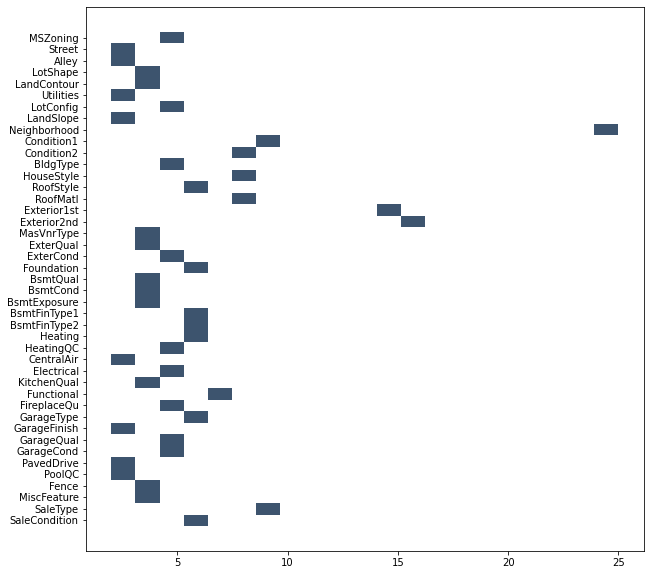

In [400]:
plt.figure(figsize=(10, 10))
sns.histplot(y=feat_categorical_nunique.index, x=feat_categorical_nunique.values)

💡 As a starter, what about simply **removing** all features that have **7 unique values or more**, and one-hot-encode every others? Let's keep ordinal encoding and statistical feature selection for the next iteration of our pipeline.

❓ Store features names to OHE in a list `feat_categorical_small` below. How many features will be OHE?

In [401]:
feat_categorical_small = feat_categorical_nunique[feat_categorical_nunique < 7]
feat_categorical_small.sum()

147

🧪 Test your code below (and clear the cell once it passed)

In [402]:
from nbresult import ChallengeResult
result = ChallengeResult('features_overview',
    n=len(feat_categorical_small))
result.write(); print(result.check())

============================= test session starts ==============================
platform linux -- Python 3.8.12, pytest-6.2.5, py-1.10.0, pluggy-1.0.0 -- /home/useradd/.pyenv/versions/lewagon/bin/python3
cachedir: .pytest_cache
rootdir: /home/useradd/code/LucaVanTichelen/data-challenges/05-ML/07-Ensemble-Methods/01-Houses-Kaggle-Competition
plugins: dash-2.0.0, anyio-3.3.2
collecting ... collected 1 item

tests/test_features_overview.py::TestFeaturesOverview::test_feat_categorical_small PASSED [100%]

============================== 1 passed in 0.01s ===============================


💯 You can commit your code:

git add tests/features_overview.pickle

git commit -m 'Completed features_overview step'

git push origin master


## 1.2 Baseline pipe

### a) Preprocessing

❓ Let's code the basic preprocessing pipeline described below. Save it under `preproc_baseline`.

For categorical features
- Simple-Impute with most frequent values
- One-Hot-Encode features that have less than 7 unique values to start with
- Drop all others features


As for numerical features
- Simple-Impute with strategy 'mean'
- Min-Max Scale 


<details>
    <summary>ℹ️ Pro tips</summary>

If you are confident, you can try sklearn's shorter syntax `make_pipeline` or `make_column_transformer` instead of the longer syntax `Pipeline` or `ColumnTransformer` if you want to avoid giving names manually to every steps.
</details>

In [403]:
X.select_dtypes(include=['int64', 'float64']).columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [404]:
list(feat_categorical_small.index)

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'BldgType',
 'RoofStyle',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleCondition']

In [405]:
make_column_selector(dtype_include=['float64', 'int64'])

In [406]:
cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])

preproc_baseline = ColumnTransformer([
    ('cat_transformer', cat_transformer, list(feat_categorical_small.index)),
    ('num_transformer', num_transformer, make_column_selector(dtype_include=['float64', 'int64']))
])

preproc_baseline

ColumnTransformer(transformers=[('cat_transformer',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['MSZoning', 'Street', 'Alley', 'LotShape',
                                  'LandContour', 'Utilities', 'LotConfig',
                                  'LandSlope', 'BldgType', 'RoofStyle',
                                  'MasVnrType', 'ExterQual', 'ExterCond',
                                  'Foundation', 'BsmtQual', 'Bsm...
                                  'BsmtExposure', 'BsmtFinType1',
                                  'BsmtFinType2', 'Heating', 'HeatingQC',
                                  'CentralAir', 'Electrical', 'KitchenQual',
                                  'FireplaceQu', 'GarageType', 'GarageFinish',
                                  'GarageQual', 'GarageCond', 'PavedDrive', ...]),
                                ('num_transformer',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', MinMaxScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f72e15428e0>)])

In [407]:
baseline_df = pd.DataFrame(preproc_baseline.fit_transform(X))
baseline_df.head()

,0,1,2,3,4,5,6,7,8,9,...,173,174,175,176,177,178,179,180,181,182
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.386460,0.000000,0.111517,0.000000,0.0,0.0,0.0,0.0,0.090909,0.50
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.324401,0.347725,0.000000,0.000000,0.0,0.0,0.0,0.0,0.363636,0.25
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.428773,0.000000,0.076782,0.000000,0.0,0.0,0.0,0.0,0.727273,0.50
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.452750,0.000000,0.063985,0.492754,0.0,0.0,0.0,0.0,0.090909,0.00
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.589563,0.224037,0.153565,0.000000,0.0,0.0,0.0,0.0,1.000000,0.50


❓ Look at the **shape** of your preprocessed dataframe.

In [408]:
shape_preproc_baseline = baseline_df.shape
shape_preproc_baseline

(1460, 183)

🧪 Test your code below

In [409]:
from nbresult import ChallengeResult
result = ChallengeResult('preproc_baseline',
    shape=shape_preproc_baseline)
result.write()
print(result.check())

============================= test session starts ==============================
platform linux -- Python 3.8.12, pytest-6.2.5, py-1.10.0, pluggy-1.0.0 -- /home/useradd/.pyenv/versions/lewagon/bin/python3
cachedir: .pytest_cache
rootdir: /home/useradd/code/LucaVanTichelen/data-challenges/05-ML/07-Ensemble-Methods/01-Houses-Kaggle-Competition
plugins: dash-2.0.0, anyio-3.3.2
collecting ... collected 1 item

tests/test_preproc_baseline.py::TestPreprocBaseline::test_shape PASSED   [100%]

============================== 1 passed in 0.01s ===============================


💯 You can commit your code:

git add tests/preproc_baseline.pickle

git commit -m 'Completed preproc_baseline step'

git push origin master


### b) Add estimator

❓ Add a simple Decision Tree model to your `preproc_baseline` and store it to `pipe_baseline` variable.

In [410]:
pipe_baseline = Pipeline([
    ('preproc', preproc_baseline),
    ('linear_regression', Ridge())
])
pipe_baseline

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('cat_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['MSZoning', 'Street',
                                                   'Alley', 'LotShape',
                                                   'LandContour', 'Utilities',
                                                   'LotConfig', 'LandSlope',
                                                   'BldgType', 'RoofStyle',
                                                   'MasVnrType', 'ExterQual',
                                                   'ExterCond', '...
                                                   'BsmtFinType2', 'Heating',
                                                   'HeatingQC', 'CentralAir',
                                                   'Electrical', 'KitchenQual',
                                                   'FireplaceQu', 'GarageType',
                                                   'GarageFinish', 'GarageQual',
                                                   'GarageCond', 'PavedDrive', ...]),
                                                 ('num_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f72e15428e0>)])),
                ('linear_regression', Ridge())])

❓ Read the Kaggle [contest evaluation rules](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview/evaluation) 
- Which performance metric do you need? Is it readily available in sklearn?
- We will need to create our custom `sklearn.metrics.scorer` object so as to pass to any cross-validation or grid search as below


👉 Create a scorer called `rmsle` using [`make_scorer`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html) that can be passed as a value for the `scoring` kwarg as below:
```python
cross_val_score(pipe_baseline, X, y, cv=5, scoring=rmsle)
```
👉 Create also the negative version `rmsle_neg` which is best when _maximized_. This will come handy later as `GridSearchCV` always tries to _maximize_ a score
```python
GridSearchCV(pipe_baseline, param_grid=..., cv=5, scoring=rmse_neg)
```

$$\text{RMSLE}(y, \hat{y}) = \sqrt{\frac{1}{n_\text{samples}} \sum_{i=0}^{n_\text{samples} - 1} (\log_e (1 + y_i) - \log_e (1 + \hat{y}_i) )^2.}$$

In [411]:
rmsle = make_scorer(mean_squared_log_error, squared=False)
rmsle_neg = make_scorer(mean_squared_log_error, squared=False, greater_is_better=False)
rmsle

make_scorer(mean_squared_log_error, squared=False)

❓5-fold cross_validate your `pipe_baseline` using this metric to get a first glance at your baseline perf.    

Store your mean score as `score_baseline`

In [420]:
score_baseline = cross_val_score(pipe_baseline, X, y, cv=5, scoring=rmsle_neg).mean()
score_baseline

-0.16642907520861666

### d) Predict baseline

❓ Predict `y_pred_baseline` from the Kaggle `test.csv` dataset you stored in the `data` folder.

In [413]:
X_test = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/houses_test_raw.csv")
X_test.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal


In [414]:
final_pipe = pipe_baseline.fit(X, y)
final_pipe.predict(X_test)

array([113256.76959388, 136811.0145436 , 174901.68834287, ...,
       157216.07718185, 111472.49591662, 234985.99120322])

❓ Finally, store your CSV ready to be submitted as `submission_baseline.csv` in the `data` folder. Read carefully the Kaggle required format and test it below (you don't need to submit this baseline online for now).

In [419]:
final_df = pd.DataFrame(final_pipe.predict(X_test))
final_df['Id'] = X_test.Id
final_df = final_df.set_index('Id')
final_df = final_df.rename(columns={0:'SalePrice'})
final_df.head()

,SalePrice
Id,
1461,113256.769594
1462,136811.014544
1463,174901.688343
1464,190322.363348
1465,187149.759609


In [416]:
final_df.to_csv('data/submission_baseline.csv')

🧪 Test your code

In [417]:
from nbresult import ChallengeResult
tmp = pd.read_csv("data/submission_baseline.csv")
result = ChallengeResult('submission_baseline',
    score_baseline = score_baseline,
    submission_shape = tmp.shape,
    submission_columns = list(tmp.columns),
    submission_dtypes = str(list(tmp.dtypes)),
)
result.write()
print(result.check())

============================= test session starts ==============================
platform linux -- Python 3.8.12, pytest-6.2.5, py-1.10.0, pluggy-1.0.0 -- /home/useradd/.pyenv/versions/lewagon/bin/python3
cachedir: .pytest_cache
rootdir: /home/useradd/code/LucaVanTichelen/data-challenges/05-ML/07-Ensemble-Methods/01-Houses-Kaggle-Competition
plugins: dash-2.0.0, anyio-3.3.2
collecting ... collected 4 items

tests/test_submission_baseline.py::TestSubmissionBaseline::test_score_baseline PASSED [ 25%]
tests/test_submission_baseline.py::TestSubmissionBaseline::test_submission_columns PASSED [ 50%]
tests/test_submission_baseline.py::TestSubmissionBaseline::test_submission_dtypes PASSED [ 75%]
tests/test_submission_baseline.py::TestSubmissionBaseline::test_submission_shape PASSED [100%]

============================== 4 passed in 0.13s ===============================


💯 You can commit your code:

git add tests/submission_baseline.pickle

git commit -m 'Completed submission_baseline step'

g

# 🏋️‍♀️ 2. ITERATIONS 

🎉 🎉 Congratulation for having fully pipelined a basline model! You will see now how easier it is to iterate and improve performance 🚀

- Your goal is to improve your prediction and submit it by **16h30 max online**
- We suggested you some improvements below: **Pick up your fights** and **incrementally** improve your pipeline as you see fit

**Estimators**

- **Tree-based ensembles (must try today)**: Probably the best suited for many categorical-features problems
- Stacking !
- XGBoost !

**Preprocessing** (once your first ensemble models works)

- Ordinal Encoding of categorical features with a hidden notion of order in their values (e.g. "bad", "average", good")
- Statistical Feature Selection to remove useless features (avoid overfitting and reduce train time)
- Predict log(SalePrice) instead?
- ...

## 2.1 Preprocessing Iteration ♲ 
(**⚠️ come back here only after you have iterated on your estimators on section 2.2)**

⏩ Collapse me if you don't use me!

### a) Ordinal Encoding (1h)

❓ Look at the following feature below. Couldn't it be encoded numerically in a wise manner?
```
ExterQual: Evaluates the quality of the material on the exterior 
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor
```

💡 Luckily, the `OrdinalEncoder` and its argument `categories`  allows us to do just that. Check it out below and make sure to understand how this works

In [423]:
# Define specific order for features
# Note: if you change this order, it will change the output for .transform()
feature_A_sorted_values = ['bad', 'average', 'good'] 
feature_B_sorted_values = ['dirty', 'clean', 'new']

encoder = OrdinalEncoder(
    categories=[
        feature_A_sorted_values,
        feature_B_sorted_values
    ],
    handle_unknown="use_encoded_value",
    unknown_value=-1
)

# Just some random training data
XX = [
    ['good', 'dirty'],
    ['bad', 'new'],
    ['average', 'clean'],
]

encoder.fit(XX)

encoder.transform([
        ['bad', "dirty"],
        ["average", "clean"],
        ['good', 'new'],
        ['bad', 'oooops never seen this label before']
])

array([[ 0.,  0.],
       [ 2.,  2.],
       [ 0., -1.]])

---
❓ **Your turn**: split your categorical preprocessor into

- `preproc_ordinal` to ordinally encode **some features** of your choice
- `preproc_nominal` to one hot encode the other ones


<details>
    <summary>Hints</summary>

- You won't be able to avoid hard-coding names and ordered values of features! Be tidy!
- It's a good practice to sort alphabetically your features to avoid bad surprises
</details>

In [426]:
X.select_dtypes(include='object').columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

### b) Statistical Feature Selection (~30min)

Our goal is to remove the least interesting features, to limit overfitting and shorten training time.  

🔥 We will make use of sklearn's [feature selection](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection) transformers directly in your pipeline!

❗️ We recommend you to **try only option 1 today to start with**. Option 2 and 3 will be corrected in Recap

In [458]:
data_corr = data.corr()['SalePrice'].sort_values(ascending=False)
new_X = data_corr[data_corr > 0.2]
new_X

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
MasVnrArea      0.477493
Fireplaces      0.466929
BsmtFinSF1      0.386420
LotFrontage     0.351799
WoodDeckSF      0.324413
2ndFlrSF        0.319334
OpenPorchSF     0.315856
HalfBath        0.284108
LotArea         0.263843
BsmtFullBath    0.227122
BsmtUnfSF       0.214479
Name: SalePrice, dtype: float64

In [464]:
data_corr

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

In [460]:
'KitchenAbvGr', 'EnclosedPorch', 'MSSubClass', 'OverallCond', 'YrSold', 'LowQualFinSF', 'Id', 'MiscVal', 'BsmtHalfBath', 'BsmtFinSF2'

0       208500
1       181500
2       223500
3       140000
4       250000
         ...  
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1460, dtype: int64

- Feel free to add a `SelectPercentile` filter at the end of your `preproc` pipeline.
- This will filter-out features that, - taken individually - least explain your target!
- The statistical test we recommend to pass to SelectPercentile is the `mutual_info_regression`

<details>
    <summary markdown='span'>🤔 Mutual Information?</summary>

- Mutual information is a *statistical* distance between two probability distributions.
- Correlation is a *linear* distance between two random variables.
- Mutual information is more general and measures the reduction of uncertainty in Y after observing X.
- On the other hand, if you already know you are working with variables that are smooth (like continuous numerical variables), sometimes correlation may tell you more about them, for instance if their relationship is monotonic.

See [animation](https://twitter.com/ari_seff/status/1409296508634152964)
</details>

In [0]:
# YOUR CODE HERE

#### (option 2) <font color=green>Multivariate</font> feature selection based their combined relationship with target `y`

🤔 We want to remove features that, when in combination with all the others, do not really help predict our target.

1️⃣ To do so, remember that we can use feature [`permutation_importance`](https://scikit-learn.org/stable/modules/permutation_importance.html) importance in combination with an estimator! It train one pipe per feature, so as to estimate which feature make our performance score *decrease* the most when shuffling it randomly. These would be our most important feature not to remove. 

Cherry on the cake, scikit-learn allows you to integrate this methodology directly into your `preproc` pipeline thanks to the `SequentialFeatureSelector` transformer: This will recursively filter-out least important features according to `feature_permutation` importance!  

However, such process can take extremely long to train when you have many features.

2️⃣ Alternatively, a faster way would be to make use of models that already outputs some measure of feature_importance when fitting them. For instance, Trees with gini-based `feature_importance_`, or Lasso regressions with L1 `coef_`. Again here, scikit-learn has coded for you a [`SelectFromModel`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html) transformer to do just that

In [ ]:
# YOUR CODE HERE

#### (option 3) <font color=green>Unsupervised</font> selection: Filter based only on the properties of `X`? 

❓ A quick-win is to remove features with the lowest variance. Think about it: a feature which only takes one value is useless (and has a variance of 0).  
- Feel free to add a `VarianceThreshold` to the end of your pipeline

# YOUR CODE HERE

❓ Additionally, we can check for correlation between our **numerical features** only

- Use [Pearson's correlation](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) combined with a heatmap to check visually whether some **numerical** features almost entirely correlated with others. 
- Use statsmodels's `VIF` to check for feature that have the highest multicolionearity

In [ ]:
# YOUR CODE HERE

❓ For **ordinal features**, we can use [Spearman's rank correlation](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) instead to check whether some **ordinally encoded** features are almost entirely "ordered" similarily than others. Feel free to plot a heatmap again

In [ ]:
# YOUR CODE HERE

❓Now, feel free to create a "filter" in your pipeline that removes any feature you want beyond a given (spearman + peasron) correlation threshold. You'll need a custom transformer class

In [ ]:
# YOUR CODE HERE

### c) Target engineering (15 min)

❓ We are asked to minimize the RMS**L**E. Why don't we transform our target to directly predict its log?
- Check-out the histogram of the target `y`.
- Normally distributed variables should be easier to predict with linear or parametric models. 
- Create `y_log` and your new performance metrics
- Don't forget at the end to take the exponential of your predictions!

In [0]:
# YOUR CODE HERE

## 2.2 Models Iteration ♻

### a ) Final version of the preproc pipeline
❓ We advise you to start with a fresh definition below so you can quickly update it as need be.

In [453]:
cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])

preproc_baseline = ColumnTransformer([
    ('cat_transformer', cat_transformer, list(feat_categorical_small.index)),
    ('num_transformer', num_transformer, make_column_selector(dtype_include=['float64', 'int64']))
])

preproc_baseline


ColumnTransformer(transformers=[('cat_transformer',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['MSZoning', 'Street', 'Alley', 'LotShape',
                                  'LandContour', 'Utilities', 'LotConfig',
                                  'LandSlope', 'BldgType', 'RoofStyle',
                                  'MasVnrType', 'ExterQual', 'ExterCond',
                                  'Foundation', 'BsmtQual', 'Bsm...
                                  'BsmtExposure', 'BsmtFinType1',
                                  'BsmtFinType2', 'Heating', 'HeatingQC',
                                  'CentralAir', 'Electrical', 'KitchenQual',
                                  'FireplaceQu', 'GarageType', 'GarageFinish',
                                  'GarageQual', 'GarageCond', 'PavedDrive', ...]),
                                ('num_transformer',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', MinMaxScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f72e138df40>)])

In [477]:
from sklearn.ensemble import GradientBoostingRegressor

pipe_baseline = Pipeline([
    ('preproc', preproc_baseline),
    ('linear_regression', GradientBoostingRegressor())
])
pipe_baseline

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('cat_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['MSZoning', 'Street',
                                                   'Alley', 'LotShape',
                                                   'LandContour', 'Utilities',
                                                   'LotConfig', 'LandSlope',
                                                   'BldgType', 'RoofStyle',
                                                   'MasVnrType', 'ExterQual',
                                                   'ExterCond', '...
                                                   'HeatingQC', 'CentralAir',
                                                   'Electrical', 'KitchenQual',
                                                   'FireplaceQu', 'GarageType',
                                                   'GarageFinish', 'GarageQual',
                                                   'GarageCond', 'PavedDrive', ...]),
                                                 ('num_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f72e138df40>)])),
                ('linear_regression', GradientBoostingRegressor())])

In [479]:
score_baseline = cross_val_score(pipe_baseline, X, y, cv=5, scoring=rmsle).mean()
score_baseline

0.13248021046727515

# 🏅FINAL SUBMISSION (submit at least 30 min before Recap)

Discover your real test score by submitting on Kaggle! 

👉 Write down your test score on the [result spreadsheet here](https://docs.google.com/spreadsheets/d/1ZEBKwa_k1Ytb0WCOh-Nopq3eaezwBNu1SAqKXEXRguc/edit#gid=0) (pick the correct batch!)

In [480]:
# YOUR CODE HERE